# Explainable and Fair Credit Default Prediction Using Historical Data



## Abstract

This project focuses on predicting the likelihood of a customer defaulting on a loan by leveraging historical credit data, with a strong emphasis on **explainability** and **fairness**. Traditional credit scoring models often function as black boxes, leading to challenges in transparency and accountability.

To address this, we employ interpretable machine learning techniques such as **SHAP (SHapley Additive exPlanations)** and **LIME (Local Interpretable Model-agnostic Explanations)** to provide clear insights into model decisions. Furthermore, the project integrates **fairness metrics** to evaluate and mitigate potential biases related to sensitive attributes like gender or age.

By balancing predictive performance with interpretability and ethical considerations, the project aims to support responsible decision-making in **credit risk assessment**.


# Table of Contents
1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Dataset Description](#dataset-description)
    - [Data Cleaning](#data-cleaning)
    - [Data Exploration](#data-exploration)
3. [Data Preprocessing](#data-preprocessing)
    - [One hot encoding](#one-hot-encoding)
    - [Data Partition](#data-partition)
    - [Feature Scaling](#feature-scaling)
    - [Dimentionality Reduction](#dimentionality-reduction)
    - [Handling class Imbalances](#handling-class-imbalances)

# Introduction

In the financial sector, assessing the **creditworthiness** of individuals is a fundamental task that significantly impacts lending decisions. Financial institutions rely on predictive models to estimate the risk of default, but many traditional scoring systems behave as opaque "black boxes"—offering little transparency into how decisions are made.

As Artificial Intelligence (AI) and Machine Learning (ML) become more prominent in credit risk modeling, there's a growing demand for systems that are not only **accurate**, but also **interpretable** and **fair**. This project addresses that need by developing a credit default prediction model using historical credit card data, while placing a strong emphasis on **explainability** and **fairness**.

To achieve this, the project employs advanced interpretability techniques such as **SHAP (SHapley Additive exPlanations)** and **LIME (Local Interpretable Model-Agnostic Explanations)** to demystify the inner workings of complex ML models. In addition, fairness metrics are used to detect and mitigate biases related to sensitive attributes like **gender** and **age**, promoting **ethical and responsible AI practices**.

Ultimately, the goal of this project is to demonstrate how machine learning can be applied in high-stakes domains like credit risk assessment in a way that is transparent, trustworthy, and fair.


# Exploratory Data Analysis


## Dataset Description

The **Default of Credit Card Clients Dataset** is sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) and contains information on the **credit history and behavior** of 30,000 credit card holders in Taiwan.

---

### 🧾 Dataset Overview

- **Source**: UCI Machine Learning Repository  
- **Original Provider**: Taiwan Economic Journal  
- **Published By**: Yeh, I.C., & Lien, C.H. (2009)  
- **Number of Instances**: 30,000  
- **Number of Features**: 23  
- **Prediction Target**: `default.payment.next.month` (1 = default, 0 = no default)

---

### 🧱 Feature Details

| Column Name                  | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| `ID`                        | Unique ID for each client                                                   |
| `LIMIT_BAL`                 | Amount of given credit (NT dollar): includes individual and family credit   |
| `SEX`                       | Gender (1 = male, 2 = female)                                               |
| `EDUCATION`                 | Education level (1 = graduate school, 2 = university, 3 = high school, etc.)|
| `MARRIAGE`                  | Marital status (1 = married, 2 = single, 3 = others)                        |
| `AGE`                       | Age in years                                                                |
| `PAY_0` to `PAY_6`          | Repayment status in months from September to April (0 = paid, 1 = delay 1 month, ..., -1 = pay duly) |
| `BILL_AMT1` to `BILL_AMT6`  | Bill statement amount (NT dollar) from September to April                   |
| `PAY_AMT1` to `PAY_AMT6`    | Amount paid in previous months (NT dollar) from September to April          |
| `default.payment.next.month` | Target variable (1 = default, 0 = no default)                              |

---

### 📌 Key Characteristics

- **Multivariate**: Numeric + categorical features  
- **Supervised Classification**: Predict default (yes/no)  
- **Real-world Financial Data**  
- **Moderate class imbalance**: ~22% defaulted clients  



### 🔗 Download

- [Direct Dataset Link (CSV)](https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls)

---



In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns
import plotly.express as px 

from tabulate import tabulate  # For pretty printing tables

from scipy.stats import gaussian_kde
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report,f1_score

from collections import Counter

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import KernelPCA

import pprint


# Data Cleaning

In [56]:
df = pd.read_csv('../data/raw/UCI_Credit_Card.csv' , index_col='ID')
df.rename(columns={'default.payment.next.month':'DEFAULT'}, inplace=True)
df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
df.rename(columns=lambda x: x.upper(), inplace=True)
df.sample(5)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
10289,150000.0,2,3,1,33,0,0,0,0,0,...,3334.0,318.0,1963.0,5000.0,4500.0,3300.0,300.0,2029.0,16368.0,0
29203,10000.0,1,3,3,22,0,0,0,0,0,...,9768.0,9233.0,9154.0,1288.0,1400.0,1200.0,300.0,800.0,500.0,1
21890,140000.0,2,1,2,25,0,0,0,0,0,...,41133.0,41730.0,42026.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,0
6655,190000.0,2,1,2,26,2,0,0,0,0,...,111487.0,114878.0,118541.0,6355.0,6500.0,5000.0,5117.0,5644.0,4767.0,1
16447,20000.0,2,1,2,54,0,0,0,4,3,...,19435.0,18835.0,18395.0,1500.0,5000.0,0.0,0.0,0.0,3000.0,1


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AMT4   

In [58]:
# Categorical variables description
df[['SEX', 'EDUCATION', 'MARRIAGE','AGE' ]].describe()


,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867,35.485500
std,0.489129,0.790349,0.521970,9.217904
min,1.000000,0.000000,0.000000,21.000000
25%,1.000000,1.000000,1.000000,28.000000
50%,2.000000,2.000000,2.000000,34.000000
75%,2.000000,2.000000,2.000000,41.000000
max,2.000000,6.000000,3.000000,79.000000


In [59]:
df['EDUCATION'].value_counts().sort_index()

EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [60]:
df['MARRIAGE'].value_counts().sort_index()

MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

Rows with undocumented values in `EDUCATION` (0, 5, 6) and `MARRIAGE` (0), totaling ~1.33% of the data, were dropped to maintain data quality.


In [61]:
print(f"Dataset size before:\t{df.shape[0]}")
df = df.drop(df[df['MARRIAGE']==0].index)
df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==5].index)
df = df.drop(df[df['EDUCATION']==6].index)
print(f"Dataset size after:\t{df.shape[0]}")


Dataset size before:	30000
Dataset size after:	29601


In [62]:
# Payment delay description
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()


,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000
mean,-0.014932,-0.131313,-0.163440,-0.218303,-0.263978,-0.287558
std,1.124503,1.199642,1.199793,1.172220,1.136217,1.152206
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [63]:
# List of repayment status columns
repayment_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Normalize repayment values for each column
for col in repayment_cols:
    # Set all negative values (paid on time or early) to -1
    df.loc[df[col] < 0, col] = -1

    # Shift non-negative values up by 1 (e.g., 0→1, 1→2) for consistency
    df.loc[df[col] >= 0, col] = df.loc[df[col] >= 0, col] + 1

    # Ensure values are stored as integers
    df[col] = df[col].astype(int)


In [64]:
## bill statement description
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()


,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,29601.000000,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000
mean,50957.432012,48942.189554,4.680320e+04,43122.554204,40235.545184,38858.449816
std,73370.242404,70923.985151,6.912389e+04,64196.383913,60699.344884,59519.893043
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3528.000000,2970.000000,2.652000e+03,2329.000000,1780.000000,1278.000000
50%,22259.000000,21050.000000,2.003500e+04,19005.000000,18091.000000,17118.000000
75%,66623.000000,63497.000000,5.983000e+04,54271.000000,50072.000000,49121.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


we have to find what do the negetive values indicate

In [65]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000,29601.000000
mean,5649.560319,5.894788e+03,5198.415898,4828.659268,4795.032735,5181.326374
std,16568.264941,2.308919e+04,17580.914806,15711.057992,15244.217154,17657.260739
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.250000e+02,390.000000,298.000000,259.000000,138.000000
50%,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5005.000000,5.000000e+03,4500.000000,4014.000000,4042.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


In [66]:
df['LIMIT_BAL'].describe()

count      29601.000000
mean      167550.544914
std       129944.020953
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

# Data Exploration
In this section, we present several graphs to explore the relationship between the input features and the target variable DEFAULT.

To begin with, it’s important to note that the dataset is significantly imbalanced — only 6,636 clients (22.1%) have defaulted. This imbalance poses a challenge, as classification models may become biased toward the majority class and fail to accurately identify defaulters if not properly addressed

In [67]:
# Visualize the distribution of the target variable
df['DEFAULT'].value_counts()


DEFAULT
0    22996
1     6605
Name: count, dtype: int64

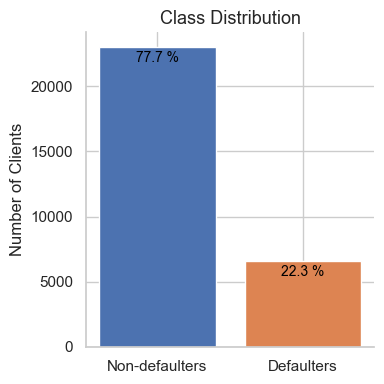

In [68]:
# Seaborn default style and color palette
sns.set_theme(style="whitegrid")  # Ensures consistency across plots
colors = sns.color_palette()[0:2]  # Take the first two default colors

# Count the class distribution
class_counts = df['DEFAULT'].value_counts().sort_index()
labels = ['Non-defaulters', 'Defaulters']

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
bars = ax.bar(labels, class_counts, color=colors)

# Add percentage labels on bars
total = class_counts.sum()
for bar, count in zip(bars, class_counts):
    pct = f'{(count / total) * 100:.1f} %'
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() - (total * 0.01),
            pct, ha='center', va='top', fontsize=10, color='black')

# Labels and title
ax.set_title('Class Distribution', fontsize=13)
ax.set_ylabel('Number of Clients')

# Clean look
sns.despine()
plt.tight_layout()

# Save the figure
plt.savefig('../images/class_distribution.svg', format='svg')
plt.show()

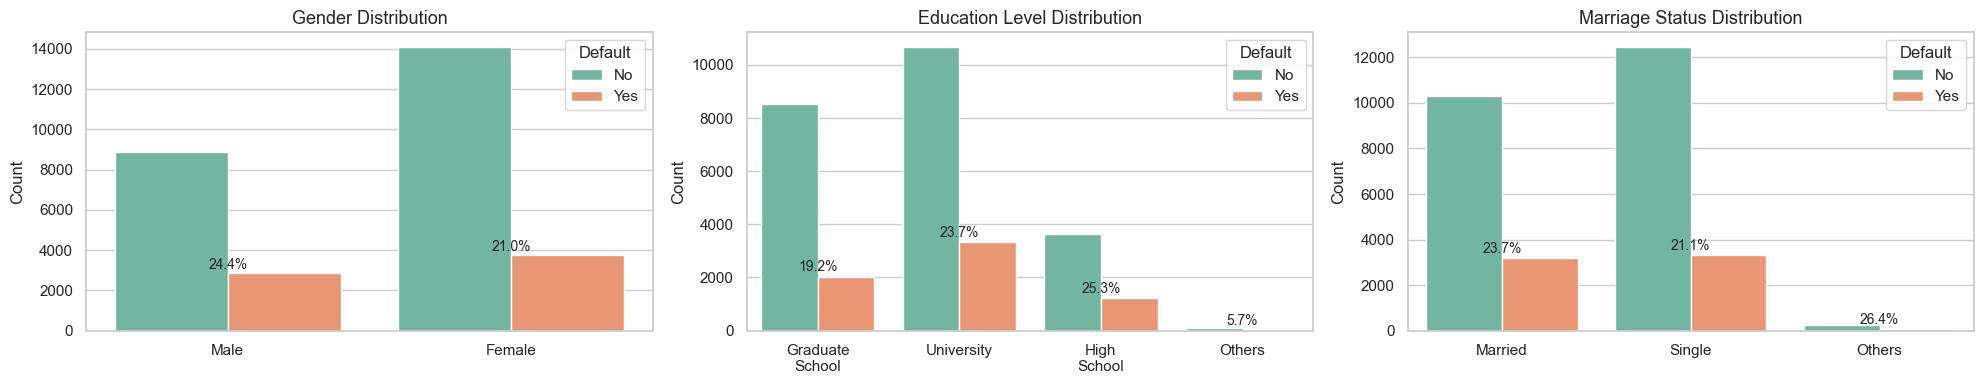

In [69]:
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")


def plot_categorical_distribution(ax, df, column, labels, title, hue='DEFAULT', order=None):
    """
    Plots the count distribution of a categorical column with hue,
    and annotates percentage of defaulters.

    Parameters:
        ax     : Matplotlib axis to plot on.
        df     : DataFrame containing the data.
        column : Column name to plot on x-axis.
        labels : List of custom tick labels.
        title  : Title of the subplot.
        hue    : Column name to use for hue (default is 'DEFAULT').
        order  : Custom order for x-axis categories.
    """
    # Plot
    sns.countplot(data=df, x=column, hue=hue, ax=ax, order=order)
    ax.set_title(title, fontsize=13)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.legend(title='Default', labels=['No', 'Yes'])

    # Calculate and annotate defaulter percentages
    grouped = df.groupby([column, hue]).size().unstack(fill_value=0)
    for i, category in enumerate(sorted(grouped.index) if order is None else order):
        total = grouped.loc[category].sum()
        defaulters = grouped.loc[category, 1]
        pct = f'{(defaulters / total) * 100:.1f}%' if total > 0 else "0.0%"
        ax.text(i, defaulters + 200, pct, ha='center', fontsize=10)


# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

# 1. Gender Distribution (SEX)
plot_categorical_distribution(
    ax=axs[0],
    df=df,
    column='SEX',
    labels=['Male', 'Female'],
    title='Gender Distribution',
    order=[1, 2]
)

# 2. Education Level Distribution (EDUCATION)
edu_df = df[df['EDUCATION'].isin([1, 2, 3, 4])]
plot_categorical_distribution(
    ax=axs[1],
    df=edu_df,
    column='EDUCATION',
    labels=['Graduate\nSchool', 'University', 'High\nSchool', 'Others'],
    title='Education Level Distribution',
    order=[1, 2, 3, 4]
)

# 3. Marriage Status Distribution (MARRIAGE)
mar_df = df[df['MARRIAGE'].isin([1, 2, 3])]
plot_categorical_distribution(
    ax=axs[2],
    df=mar_df,
    column='MARRIAGE',
    labels=['Married', 'Single', 'Others'],
    title='Marriage Status Distribution',
    order=[1, 2, 3]
)

# Final layout and save
plt.tight_layout()
plt.savefig('../images/categorical_distribution.svg', format='svg')
plt.show()


Although the data suggests the following trends:

1. The percentage of defaults is higher among men compared to women.  
2. An increase in education level appears to reduce the risk of default.  
3. Married individuals tend to exhibit a higher risk of default.

These patterns alone do not confirm a true dependency, as they may simply be due to chance. To assess whether these observed differences are statistically significant, we apply the **Chi-Square Test of Independence**.

### Hypotheses for the Chi-Square Test

- **Null Hypothesis (H₀):**  
  There is no association between the categorical variable (e.g., education level) and loan default status — any differences are due to random variation.

- **Alternative Hypothesis (H₁):**  
  There is a statistically significant association between the categorical variable and loan default status — the observed differences are not due to chance.



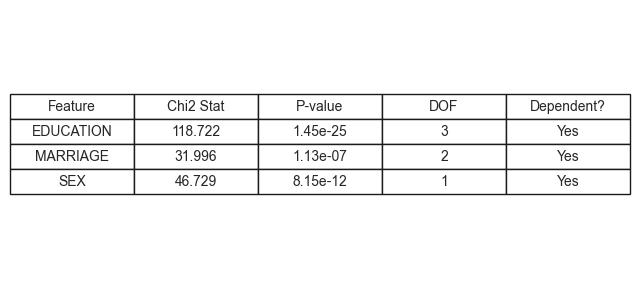

In [70]:

#  Function to run Chi-Square test
def run_chi_square_test(df, feature, target='DEFAULT'):
    contingency = pd.crosstab(df[feature], df[target])
    chi2_stat, pvalue, dof, expected = chi2_contingency(contingency)
    return {
        'Feature': feature,
        'Chi2 Stat': round(chi2_stat, 3),
        'P-value': f"{pvalue:.2e}",
        'DOF': dof,
        'Dependent?': 'Yes' if pvalue < 0.05 else 'No'
    }

# Run tests
features_to_test = ['EDUCATION', 'MARRIAGE', 'SEX']
results = [run_chi_square_test(df, feature) for feature in features_to_test]

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Plot the table
fig, ax = plt.subplots(figsize=(8, 2 + 0.5*len(results)))  # auto adjust height
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Save as image
plt.savefig("../images/chi_square_results_table.png", bbox_inches='tight')
plt.show()


Based on the results of the Chi-Square tests, we conclude that the observed dependencies are statistically significant and not the result of random chance.


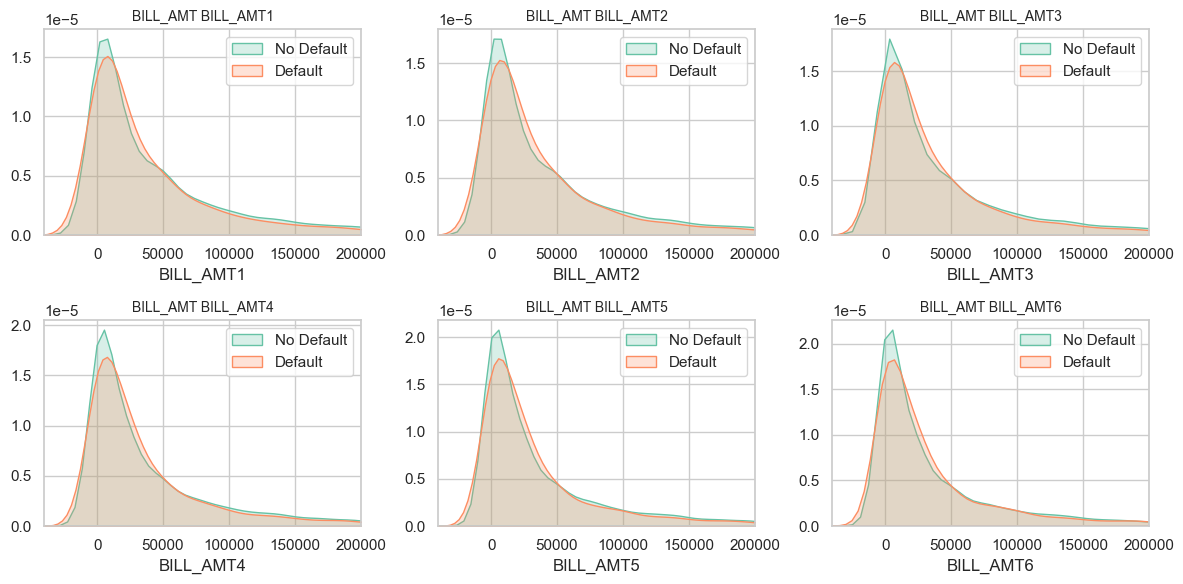

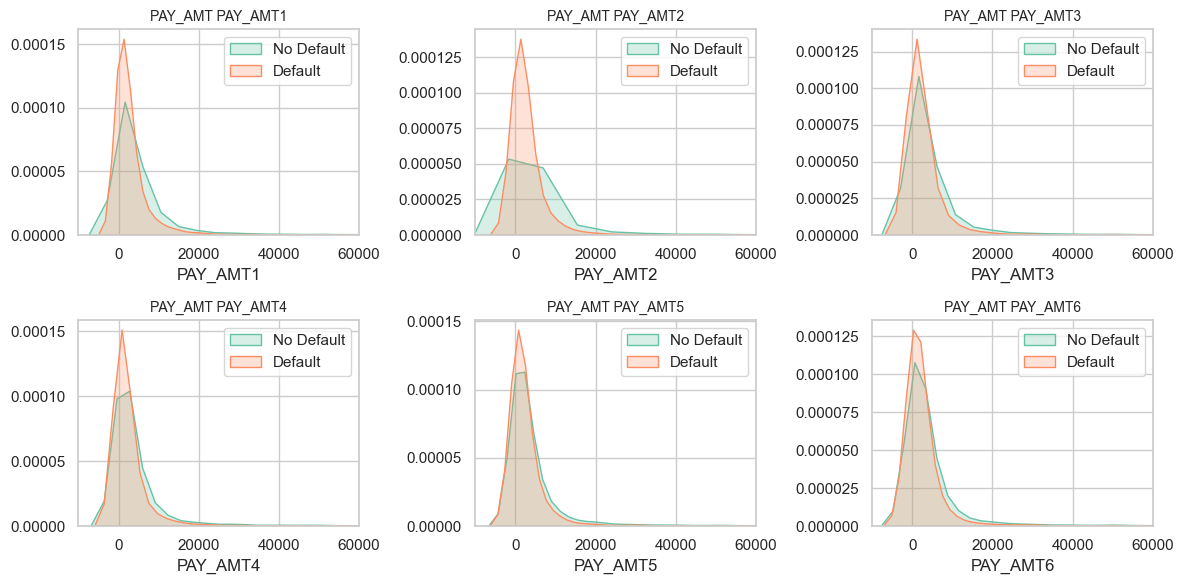

In [71]:
def plot_kde_by_default(df, cols, title_prefix, xlim_range, save_path):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(cols):
        plt.subplot(2, 3, i + 1)

        for default_val in [0, 1]:
            sns.kdeplot(
                df.loc[df['DEFAULT'] == default_val, col],
                label='Default' if default_val == 1 else 'No Default',
                color=sns.color_palette()[default_val],
                fill=True
            )

        plt.xlim(xlim_range)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('')
        plt.legend()
        plt.title(f"{title_prefix} {col}", fontsize=10)
        plt.tight_layout()

    plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()

# Column lists
BILL_AMT_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
PAY_AMT_cols =  ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Plot and save
plot_kde_by_default(df, BILL_AMT_cols, 'BILL_AMT', xlim_range=(-40000, 200000), save_path='../images/continuousBILLAMT.svg')
plot_kde_by_default(df, PAY_AMT_cols, 'PAY_AMT', xlim_range=(-10000, 60000), save_path='../images/continuousPAYAMT.svg')


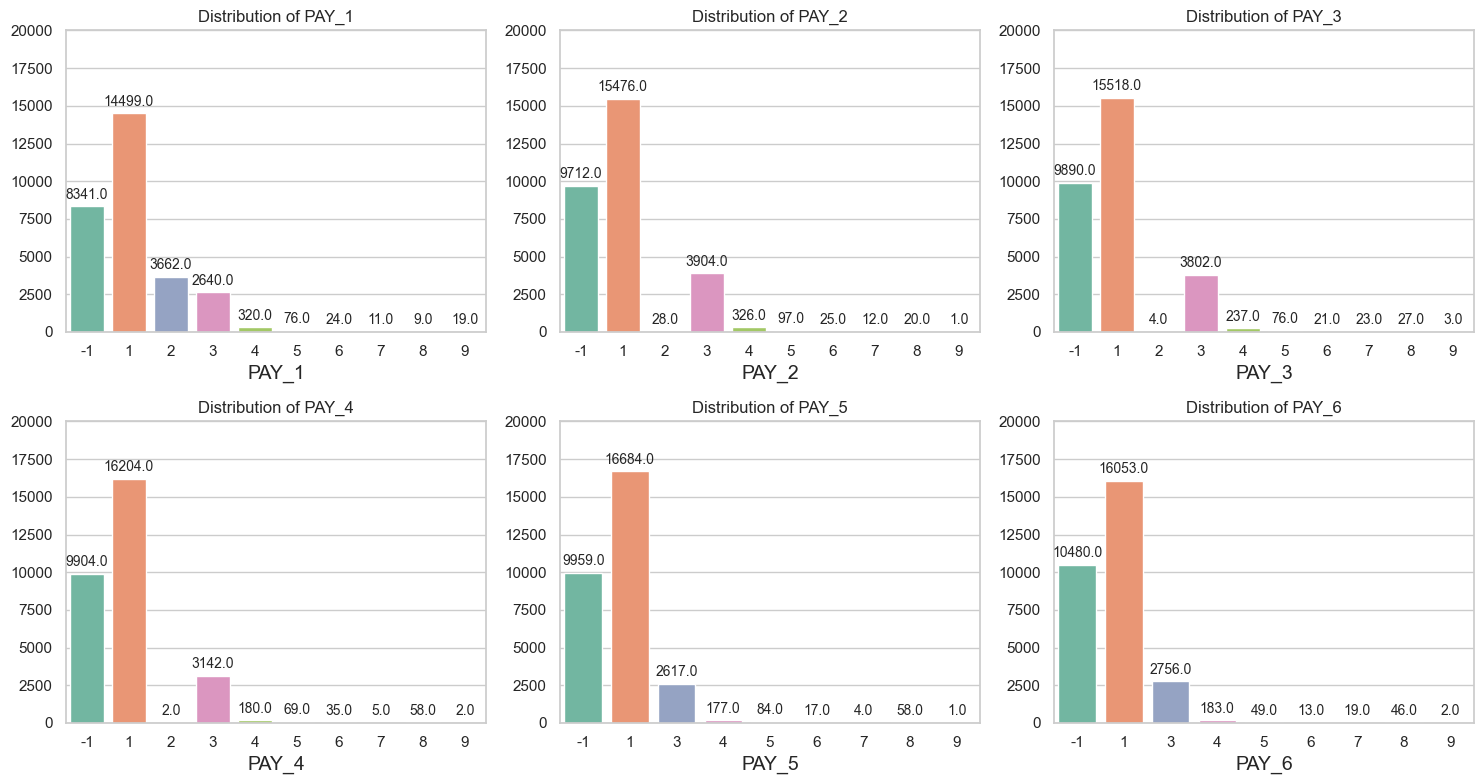

In [72]:
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

# PAY columns
PAY_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Modular function to plot PAY_* feature distributions
def plot_pay_status_distribution(df, cols, save_path):
    plt.figure(figsize=(15, 8))

    for i, col in enumerate(cols):    
        plt.subplot(2, 3, i + 1)

        # Assign hue=col and legend=False to avoid warning
        ax = sns.countplot(x=col, hue=col, data=df, palette="Set2", legend=False)
        plt.ylim(0, 20000)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('')
        plt.title(f'Distribution of {col}', fontsize=12)

        # Annotate each bar
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2.0, height + 500),
                        ha='center', fontsize=10)

        plt.tight_layout()

    plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()

# Call the function
plot_pay_status_distribution(df, PAY_cols, save_path='../images/categoricalPAY.svg')


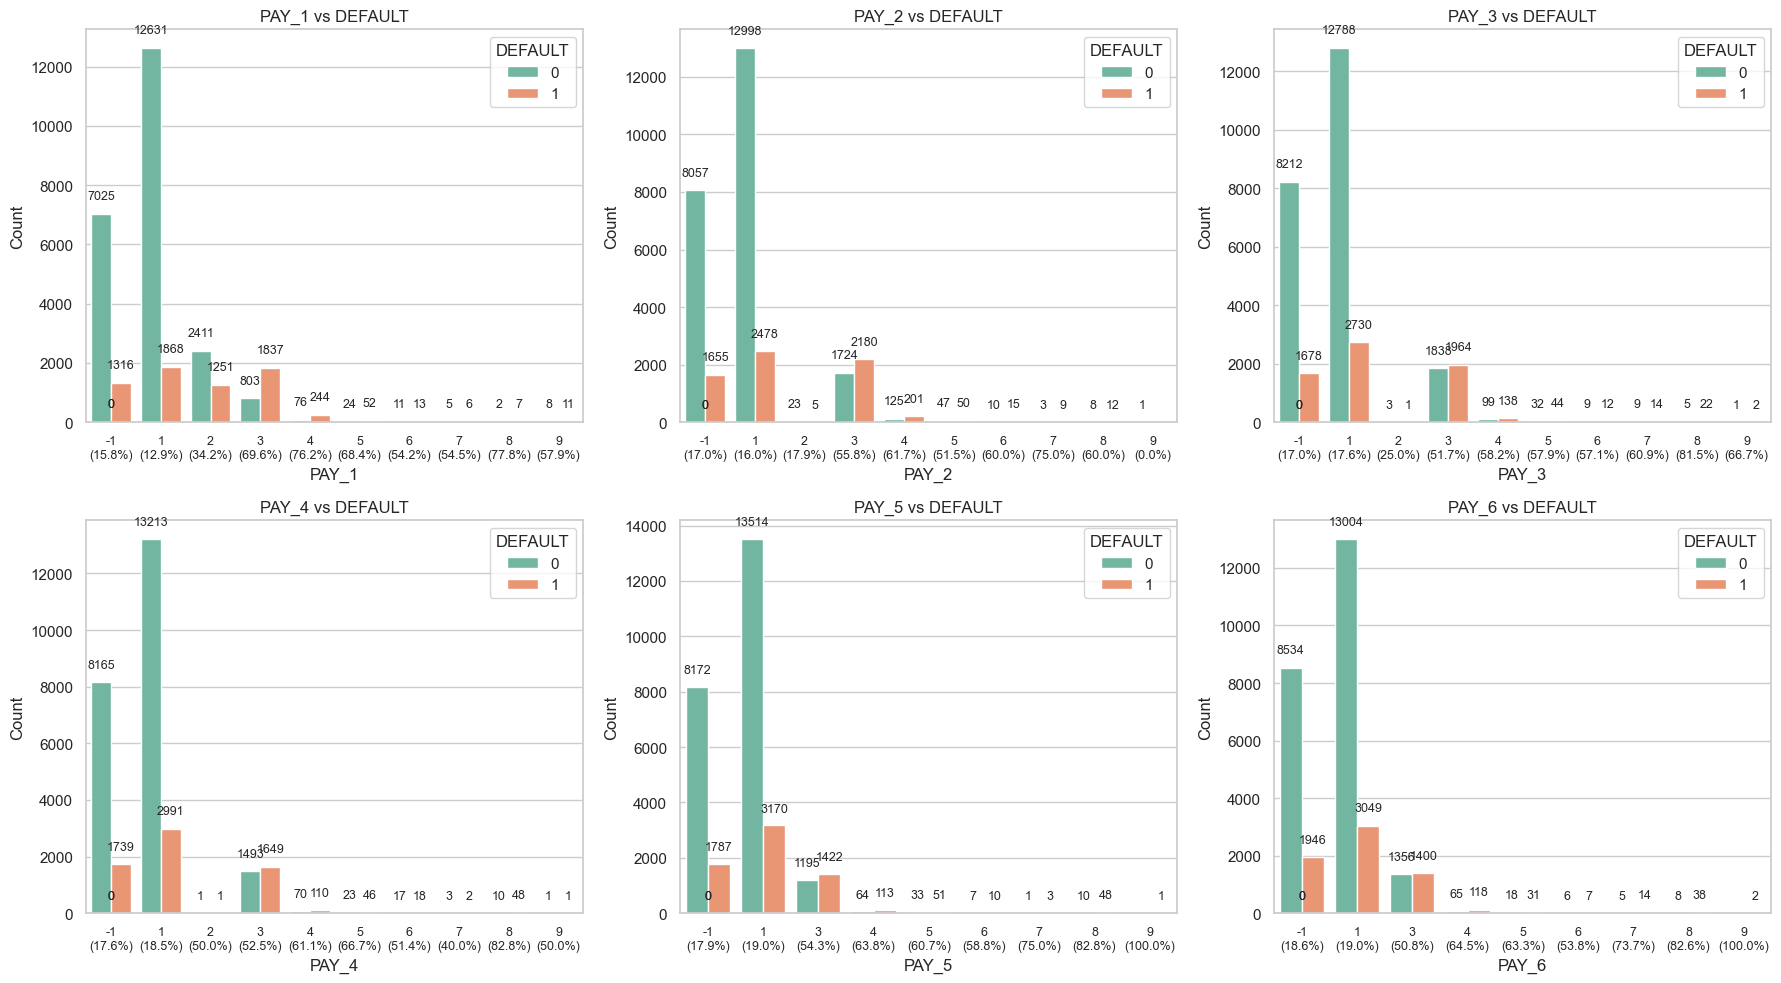

In [73]:

sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

PAY_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

def plot_default_distribution(df, cols, save_path):
    plt.figure(figsize=(18, 10))

    for i, col in enumerate(cols):
        plt.subplot(2, 3, i + 1)

        ax = sns.countplot(x=col, hue='DEFAULT', data=df, palette="Set2")

        # Compute % default per category
        pct_df = df.groupby(col)['DEFAULT'].value_counts(normalize=False).unstack().fillna(0)
        pct_df['Total'] = pct_df.sum(axis=1)
        pct_df['Default %'] = (pct_df[1] / pct_df['Total'] * 100).round(1)

        # Annotate bar counts
        for bar in ax.patches:
            x = bar.get_x() + bar.get_width() / 2.0
            height = int(bar.get_height())
            ax.annotate(f'{height}', (x, height + 500), ha='center', fontsize=9)

        # Fix tick positions and set combined labels
        xticks = sorted(df[col].dropna().unique())
        tick_positions = list(range(len(xticks)))
        tick_labels = [f"{x}\n({pct_df.loc[x, 'Default %']}%)" if x in pct_df.index else str(x) for x in xticks]

        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=0, fontsize=9)

        plt.title(f'{col} vs DEFAULT', fontsize=12)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count")
        plt.legend(title="DEFAULT", loc='upper right')

    plt.tight_layout()
    plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()

# Call the function
plot_default_distribution(df, PAY_cols, save_path='../images/PAY_default_grouped.svg')


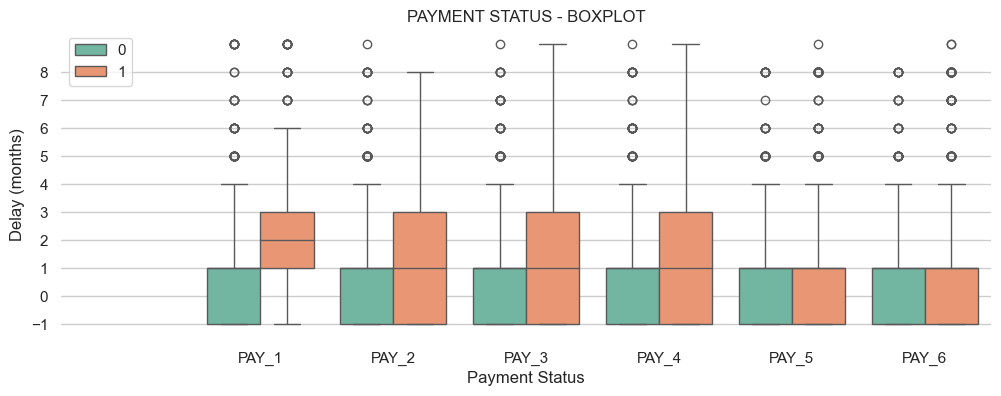

In [74]:
repayment = df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT']]
repayment = pd.melt(repayment, 
                    id_vars="DEFAULT",
                    var_name="Payment Status",
                    value_name='Delay (months)')


plt.figure(figsize=(12,4))
sns.boxplot(y="Delay (months)", x="Payment Status", hue="DEFAULT", data=repayment, palette=sns.set_palette("Set2")
)
plt.xlim([-1.5,5.5])
plt.ylim([-1.5,9.5])
plt.yticks(np.arange(-1,9))
plt.title('PAYMENT STATUS - BOXPLOT')
plt.legend()
plt.savefig('../images/BoxplotPAY.svg')
plt.box(False)

### Insights from Payment Status Features

The distribution of payment status across months, visualized using boxplots and the grouped count plot , reveals that clients who delay payments by one month or less are significantly less likely to default on their credit card payments. Among all the repayment months, the status for September (`PAY_1`) demonstrates the highest discriminative power in identifying defaulters, making it a critical feature in predicting credit risk.


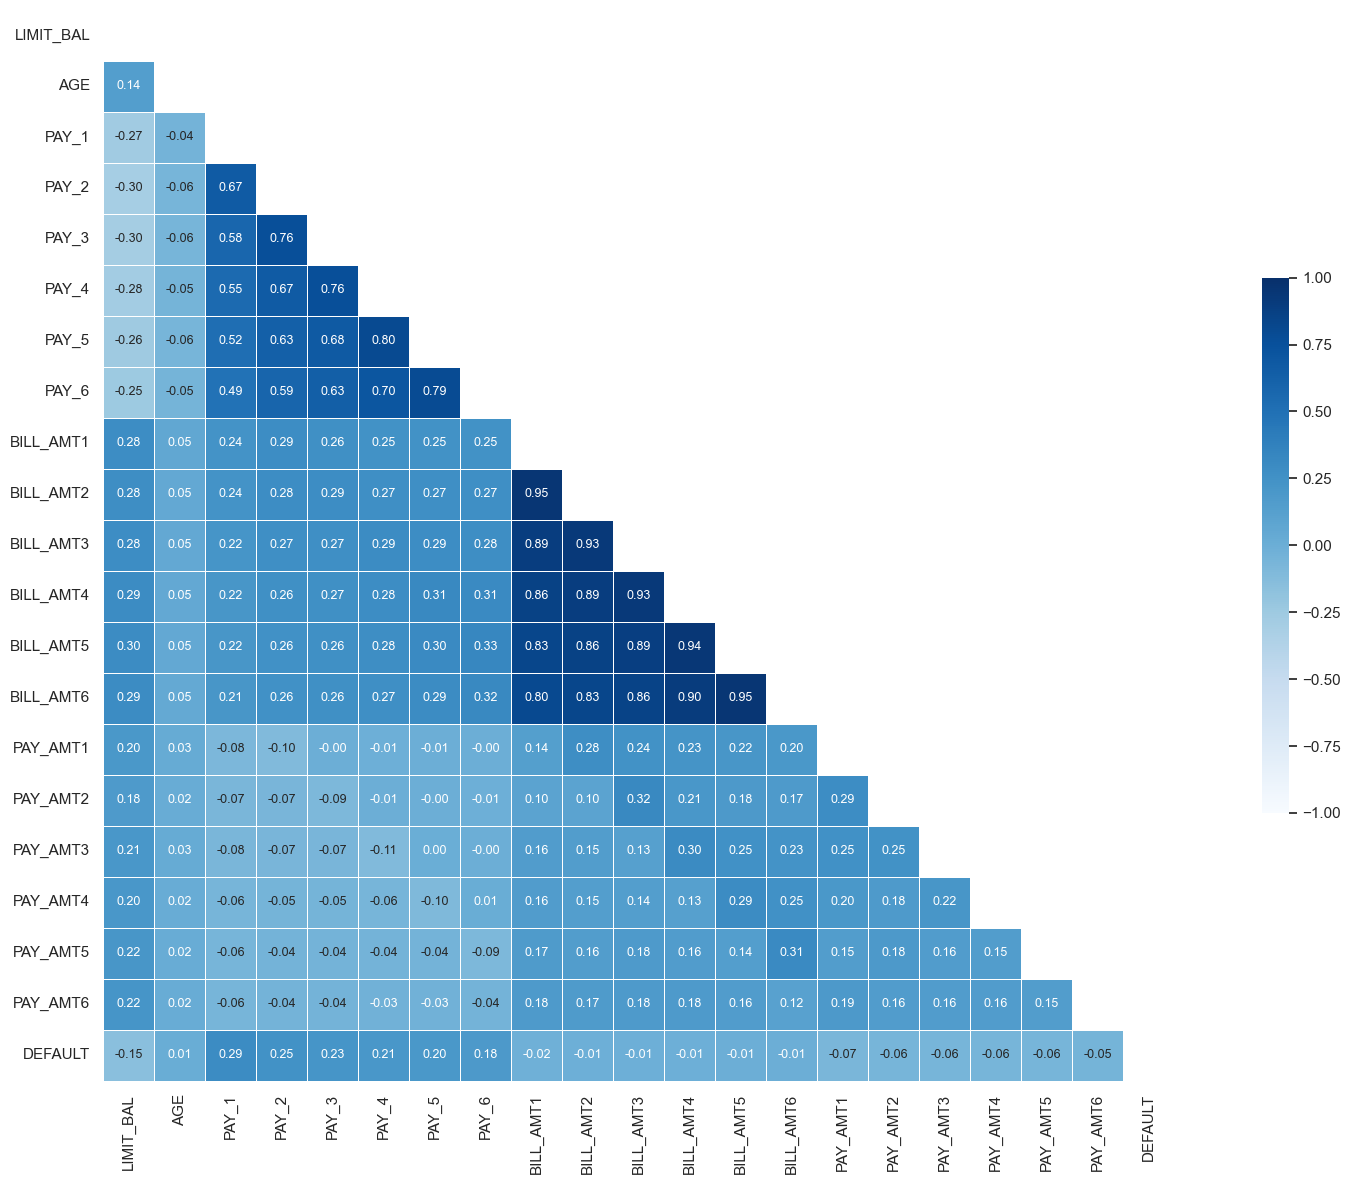

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns including the target
numeric_cols = [
    'LIMIT_BAL', 'AGE', 
    'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'DEFAULT'
]

# Compute the correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set theme and plot size
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(18, 12))

# Draw the heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='Blues',
    vmax=1, vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9},
    cbar_kws={"shrink": 0.5}
)

# Save the figure
plt.tight_layout()
plt.savefig('../images/correlation.svg', format='svg')
plt.show()


We note that there is a strong positive correlation between the `BILL_AMTn` and `PAY_n` features, which may indicate a redundancy of information. .

Text(0.5, 0, 'Default')

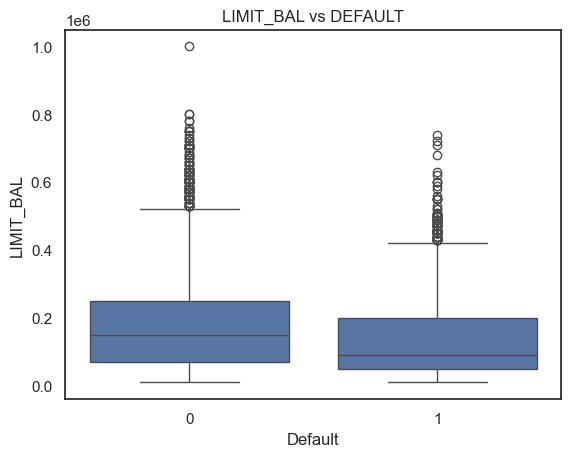

In [76]:
sns.boxplot(x='DEFAULT', y='LIMIT_BAL', data=df)
plt.title('LIMIT_BAL vs DEFAULT')
plt.xlabel('Default')   

It is apparent from our box plot, that the Credit Limit by itself is not a good predictor of Default. It is true that the mean Credit Limit of those Defaulted is smaller, but there is much common ground between the 2 distributions.
Nevertheless, it is highly likelly that combining this column with some other features, can have many benefits. 


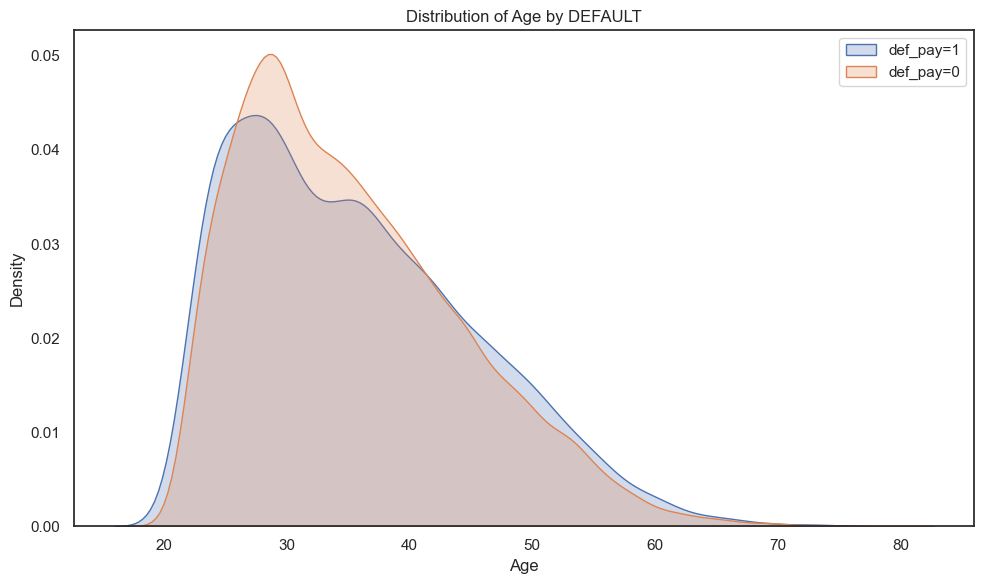

In [77]:
# age and default density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['DEFAULT'] == 1], x='AGE', label='def_pay=1', fill=True)
sns.kdeplot(data=df[df['DEFAULT'] == 0], x='AGE', label='def_pay=0', fill=True)
plt.title('Distribution of Age by DEFAULT')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('../images/DensityPlotAge.svg')

plt.show()



between age 30 - 40 people are more likely to default 


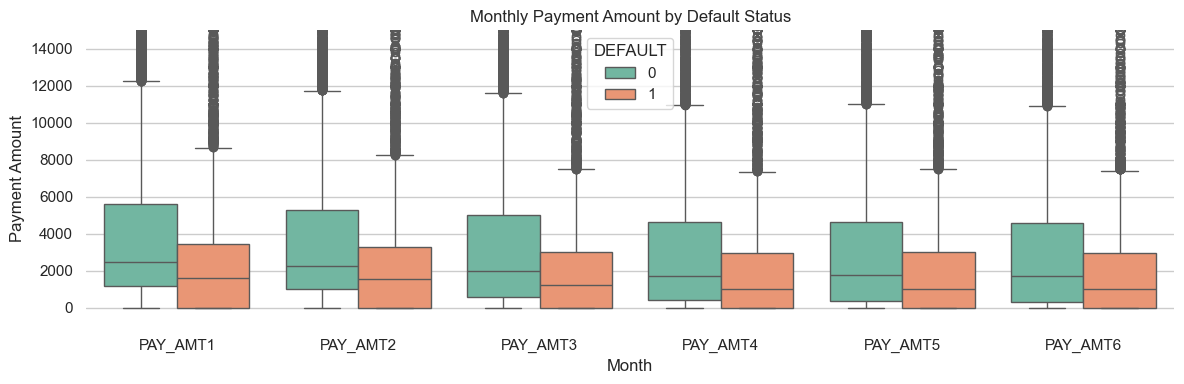

In [78]:
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

# Melt PAY_AMT data
pay_amt = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT']]
pay_amt = pd.melt(pay_amt,
                  id_vars="DEFAULT",
                  var_name="Month",
                  value_name='Payment Amount')

# Plot boxplot
plt.figure(figsize=(12, 4))
sns.boxplot(y="Payment Amount", x="Month", hue="DEFAULT", data=pay_amt)

# Customize plot
plt.ylim([-1000, 15000])  # Adjust based on your data distribution
plt.title('Monthly Payment Amount by Default Status')
plt.legend(title='DEFAULT')
plt.box(False)
plt.tight_layout()

# Save figure
plt.savefig('../images/BoxplotPAY_AMT.svg')
plt.show()


### Monthly Payment Amount and Default Status

The boxplots comparing monthly payment amounts (`PAY_AMT1` to `PAY_AMT6`) reveal that customers who did **not default** generally made **larger payments** than those who defaulted. Across all six months, the **median payments** of non-defaulters were consistently higher than those of defaulters. This suggests that **lower payment amounts are associated with an increased likelihood of defaulting**. The presence of numerous outliers among both groups also highlights the variability in individual repayment behaviors, though the central tendency remains a key differentiating factor.


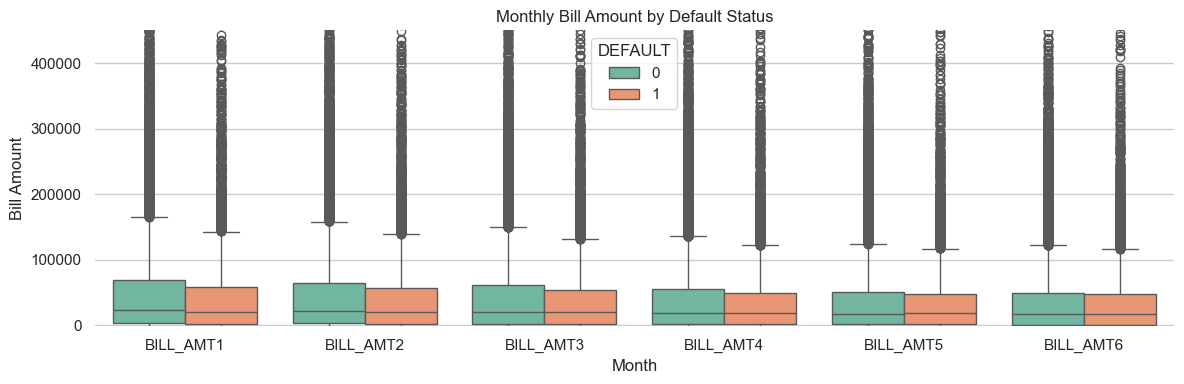

In [79]:
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

# Melt PAY_AMT data
pay_amt = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'DEFAULT']]
pay_amt = pd.melt(pay_amt,
                  id_vars="DEFAULT",
                  var_name="Month",
                  value_name='Bill Amount')

# Plot boxplot
plt.figure(figsize=(12, 4))
sns.boxplot(y="Bill Amount", x="Month", hue="DEFAULT", data=pay_amt)

# Customize plot
plt.ylim([-1000, 450000])  # Adjust based on your data distribution
plt.title('Monthly Bill Amount by Default Status')
plt.legend(title='DEFAULT')
plt.box(False)
plt.tight_layout()

# Save figure
plt.savefig('../images/BoxplotBILL_AMT.svg')
plt.show()


no significant correlation between BILL_AMT and DEFAULT

# Data Preprocessing
- **One-hot encoding** of catagorical data
- 1 : 4 statified splitting of testing and training data

# One hot encoding

In [80]:
df['GRAD_SCHOOL'] = (df['EDUCATION'] == 1).astype('category')
df['UNIVERSITY'] = (df['EDUCATION'] == 2).astype('category')
df['HIGH_SCHOOL'] = (df['EDUCATION'] == 3).astype('category')
df.drop('EDUCATION', axis=1, inplace=True)

df['MALE'] = (df['SEX'] == 1).astype('category')
df.drop('SEX', axis=1, inplace=True)

df['MARRIED'] = (df['MARRIAGE'] == 1).astype('category')
df.drop('MARRIAGE', axis=1, inplace=True)

df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,24,3,3,-1,-1,-1,-1,3913.0,3102.0,...,0.0,0.0,0.0,0.0,1,False,True,False,False,True
2,120000.0,26,-1,3,1,1,1,3,2682.0,1725.0,...,1000.0,1000.0,0.0,2000.0,1,False,True,False,False,False
3,90000.0,34,1,1,1,1,1,1,29239.0,14027.0,...,1000.0,1000.0,1000.0,5000.0,0,False,True,False,False,False
4,50000.0,37,1,1,1,1,1,1,46990.0,48233.0,...,1200.0,1100.0,1069.0,1000.0,0,False,True,False,False,True
5,50000.0,57,-1,1,-1,1,1,1,8617.0,5670.0,...,10000.0,9000.0,689.0,679.0,0,False,True,False,True,True


# Data Partition

In [81]:
y = df['DEFAULT']
X = df.drop(columns='DEFAULT')
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=24
)
def generate_split_summary(X_train, X_test, y_train, y_test):
    summary = pd.DataFrame({
        "Set": ["Train", "Train", "Test", "Test"],
        "Class": ["Non-defaulters", "Defaulters", "Non-defaulters", "Defaulters"],
        "Count": [
            (y_train == 0).sum(),
            (y_train == 1).sum(),
            (y_test == 0).sum(),
            (y_test == 1).sum()
        ]
    })
    return summary

# Plot and save the table as an image
def save_summary_table_as_svg(summary_df, filename):
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=summary_df.values,
        colLabels=summary_df.columns,
        cellLoc='center',
        loc='center'
    )
    table.scale(1.2, 1.5)
    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.close()

# Run and save
summary_df = generate_split_summary(X_train_raw, X_test_raw, y_train, y_test)
save_summary_table_as_svg(summary_df, '../images/class_distribution_split.svg')


# Feature Scaling

Feature scaling ensures that all numerical features contribute equally to model training. While tree-based models (e.g., decision trees, random forests) are scale-invariant, many algorithms benefit from scaled input.

Two common methods:
- **Normalization** (Min-Max Scaling): Rescales features to \[0, 1\]
  $$
  X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}
  $$
- **Standardization**: Centers features at mean 0 and scales to unit variance
  $$
  Z = \frac{X - \mu}{\sigma}
  $$

We apply scaling using statistics from the **training set only** to avoid data leakage.

> Since our modeling technique is sensitive to outliers, and normalization suppresses their effect better than standardization, we proceed with **normalized data**.


In [82]:

# Columns to scale
scale_cols = ['LIMIT_BAL', 'AGE'] + \
             [f'PAY_{i}' for i in range(1, 7)] + \
             [f'BILL_AMT{i}' for i in range(1, 7)] + \
             [f'PAY_AMT{i}' for i in range(1, 7)]

# Initialize scaler
scaler = MinMaxScaler()

# Fit on training data only and transform both sets
X_train_norm = X_train_raw.copy()
X_test_norm = X_test_raw.copy()

X_train_norm[scale_cols] = scaler.fit_transform(X_train_raw[scale_cols])
X_test_norm[scale_cols] = scaler.transform(X_test_raw[scale_cols])


# Dimentionality Reduction 

# 🔍 Choosing the Right Path: Interpretability vs Performance

In this notebook, we explore two possible paths for feature reduction and model explainability in the context of credit card default prediction. Our goal is to balance model performance with transparency.

---

## 🛣️ Path 1: High Interpretability — Feature Selection + SHAP

We select the most relevant original features using methods like `SelectKBest` or `RFE`. These selected features are directly used to train an interpretable model (e.g., Logistic Regression or XGBoost).  
We then apply **SHAP** to explain predictions in terms of actual input features — enabling clear and regulator-friendly insights.

> 🔹 Best suited when interpretability is the top priority.

---

## 🛣️ Path 2: Balanced Approach — PCA + modle + SHAP

We apply **PCA** to reduce dimensionality while retaining most of the variance. The transformed components are fed into a  model.  
SHAP is used to explain the model, though explanations are in terms of principal components and may require mapping back to original features.

> 🔹 Best suited when we want good performance with reasonable interpretability.

---

## ⚖️ Summary

| Feature         | Path 1: Feature Selection | Path 2: PCA + SHAP     |
|----------------|---------------------------|------------------------|
| Interpretability | ✅ High (clear)            | ⚠️ Moderate (indirect) |
| Performance     | ⚪ Baseline                | ✅ Often better         |
| SHAP Clarity    | ✅ Direct                  | ⚠️ Needs mapping        |
| Use Case        | Regulatory, EDA           | Performance tuning     |


In [83]:
X_train_norm.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED
ID,,,,,,,,,,,,,,,,,,,,,
10013,0.037975,0.241379,0.2,0.2,0.2,0.2,0.2,0.2,0.210853,0.127831,...,0.004075,0.005624,0.008052,0.017584,0.008694,True,False,False,False,False
6653,0.658228,0.500000,0.2,0.2,0.2,0.2,0.2,0.2,0.422475,0.358661,...,0.008149,0.011248,0.011272,0.016412,0.009458,False,False,True,False,True
18965,0.202532,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,0.237815,0.142044,...,0.001715,0.002752,0.001932,0.007034,0.003783,False,True,False,False,False
8746,0.265823,0.120690,0.0,0.0,0.0,0.0,0.0,0.0,0.208879,0.114019,...,0.000000,0.000000,0.000000,0.000000,0.000000,True,False,False,False,False
29192,0.240506,0.137931,0.0,0.0,0.0,0.0,0.0,0.0,0.196565,0.100838,...,0.023963,0.017800,0.009911,0.023340,0.037402,False,True,False,True,False


In [84]:
featuresToReduce = [f'PAY_{i}' for i in range(1, 7)] + \
             [f'BILL_AMT{i}' for i in range(1, 7)] + \
             [f'PAY_AMT{i}' for i in range(1, 7)]


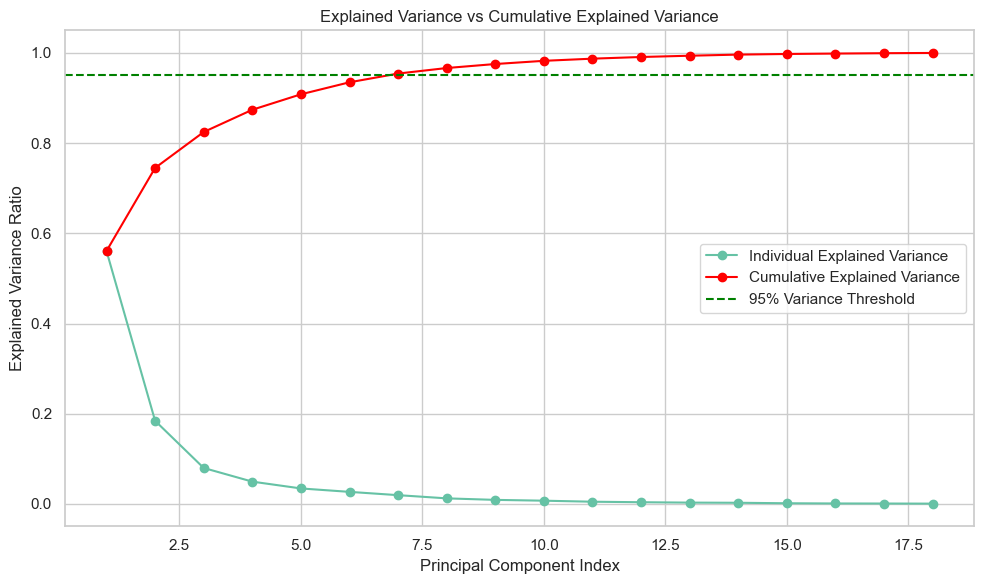

In [85]:

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_norm[featuresToReduce])

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

#Plot the graph using a line plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative Explained Variance', color='red')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs Cumulative Explained Variance')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% Variance Threshold')  # Optional threshold line
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
X_train_norm

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED
ID,,,,,,,,,,,,,,,,,,,,,
10013,0.037975,0.241379,0.2,0.2,0.2,0.2,0.2,0.2,0.210853,0.127831,...,0.004075,0.005624,0.008052,0.017584,0.008694,True,False,False,False,False
6653,0.658228,0.500000,0.2,0.2,0.2,0.2,0.2,0.2,0.422475,0.358661,...,0.008149,0.011248,0.011272,0.016412,0.009458,False,False,True,False,True
18965,0.202532,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,0.237815,0.142044,...,0.001715,0.002752,0.001932,0.007034,0.003783,False,True,False,False,False
8746,0.265823,0.120690,0.0,0.0,0.0,0.0,0.0,0.0,0.208879,0.114019,...,0.000000,0.000000,0.000000,0.000000,0.000000,True,False,False,False,False
29192,0.240506,0.137931,0.0,0.0,0.0,0.0,0.0,0.0,0.196565,0.100838,...,0.023963,0.017800,0.009911,0.023340,0.037402,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,0.177215,0.241379,0.2,0.2,0.2,0.0,0.0,0.0,0.247256,0.172216,...,0.024448,0.061122,0.000000,0.004991,0.000000,False,True,False,True,False
20056,0.278481,0.413793,0.0,0.0,0.0,0.0,0.0,0.0,0.181479,0.083212,...,0.000000,0.000000,0.000000,0.000319,0.002332,True,False,False,False,True
6800,0.088608,0.051724,0.2,0.2,0.2,0.2,0.2,0.4,0.210161,0.114284,...,0.001131,0.001125,0.003510,0.000000,0.001757,False,True,False,True,False


In [87]:
n_components = 7

# Apply PCA only on selected columns
pca = PCA(n_components=n_components)

# Perform PCA transformation
X_train_pca_values = pca.fit_transform(X_train_norm[featuresToReduce])
X_test_pca_values = pca.transform(X_test_norm[featuresToReduce])

# Convert PCA output to DataFrames with new column names
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]
X_train_pca_df = pd.DataFrame(X_train_pca_values, columns=pca_columns, index=X_train_norm.index)
X_test_pca_df = pd.DataFrame(X_test_pca_values, columns=pca_columns, index=X_test_norm.index)

# Drop the original features that were reduced
X_train_remaining = X_train_norm.drop(columns=featuresToReduce)
X_test_remaining = X_test_norm.drop(columns=featuresToReduce)

# Concatenate the remaining features with the PCA components
X_train_final_pca = pd.concat([X_train_remaining, X_train_pca_df], axis=1)
X_test_final_pca = pd.concat([X_test_remaining, X_test_pca_df], axis=1)
X_train_final_pca.head()

,LIMIT_BAL,AGE,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
ID,,,,,,,,,,,,,,
10013,0.037975,0.241379,True,False,False,False,False,0.074288,-0.065211,-0.022738,0.004911,0.006429,0.000670,-0.000615
6653,0.658228,0.500000,False,False,True,False,True,0.237786,0.424537,-0.001278,-0.005582,-0.007174,-0.002709,0.006100
18965,0.202532,0.137931,False,True,False,False,False,0.086213,-0.030817,-0.019933,0.003801,0.005468,-0.000388,-0.000403
8746,0.265823,0.120690,True,False,False,False,False,-0.409587,0.026495,-0.027591,-0.031136,0.005505,-0.005059,-0.001876
29192,0.240506,0.137931,False,True,False,True,False,-0.404990,0.044291,-0.029810,-0.030538,0.004291,-0.007187,-0.001222


X_train_final_pca , X_test_final_pca contain pca reduces columns
X_train_norm , X_test_norm have non pca reduced colums 
we would compare modle performace and explaininablity on these models

# Handling class Imbalances

When working with imbalanced datasets, it's common to apply resampling techniques to ensure the model learns both classes equally. This document explains the theory and implementation algorithm of three popular resampling strategies:

- Cluster Centroid Undersampling
- Simple SMOTE
- KMeans-SMOTE

---

## 1. Cluster Centroid Undersampling

### Theory:
This technique reduces the number of majority class samples by clustering them using KMeans and replacing the actual samples with the centroids of those clusters. It is an **undersampling** method.

### Goal:
To reduce over-representation of the majority class while retaining its overall distribution characteristics.

### Algorithm:
1. Separate the data into majority and minority class subsets.
2. Set `target_count` to the number of minority samples (or a specified value).
3. Apply KMeans clustering on the majority class with `target_count` clusters.
4. Use the resulting centroids as the new majority samples.
5. Combine centroids with all original minority samples to form the new dataset.

---

## 2. Simple SMOTE (Synthetic Minority Oversampling Technique)

### Theory:
SMOTE creates synthetic samples of the minority class by interpolating between existing minority instances and their nearest neighbors. This is an **oversampling** method.

### Goal:
To balance the dataset by generating synthetic samples for the minority class.

### Algorithm:
1. Isolate minority and majority class samples.
2. Train a k-NN model (default `k=5`) on the minority samples.
3. For each new sample to be generated:
   - Randomly select a minority instance `x_i`
   - Randomly choose one of its k nearest neighbors `x_j`
   - Generate a new point using linear interpolation:
     ```
     x_new = x_i + gap * (x_j - x_i), where gap ∈ [0, 1]
     ```
4. Repeat until the desired number of synthetic samples is reached.
5. Append these synthetic samples to the original dataset.

---

## 3. KMeans-SMOTE

### Theory:
KMeans-SMOTE combines clustering with SMOTE. It first clusters the minority class and then applies SMOTE within each cluster. This helps in generating more realistic synthetic samples that respect the structure of the data.

### Goal:
To improve the quality of synthetic samples by applying SMOTE within local neighborhoods (clusters).

### Algorithm:
1. Separate majority and minority class data.
2. Use KMeans to cluster the minority class into `n_clusters` (default: √len(minority samples)).
3. For each cluster:
   - Use k-NN to find neighbors within the cluster.
   - Generate synthetic samples using SMOTE-style interpolation:
     ```
     x_new = x_i + gap * (x_j - x_i)
     ```
   - Repeat until the total required number of synthetic samples is generated.
4. Combine all original data with the newly generated samples.

---

## Summary Table

| Method                  | Type          | Description                                      | Suitable When                            |
|------------------------|---------------|--------------------------------------------------|------------------------------------------|
| Cluster Centroid       | Undersampling | Replace majority class with KMeans centroids     | Majority class is very large or redundant |
| Simple SMOTE           | Oversampling  | Interpolate between nearest neighbors            | Minority class is well spread            |
| KMeans-SMOTE           | Oversampling  | Apply SMOTE within clustered minority data       | Minority class has internal clusters     |


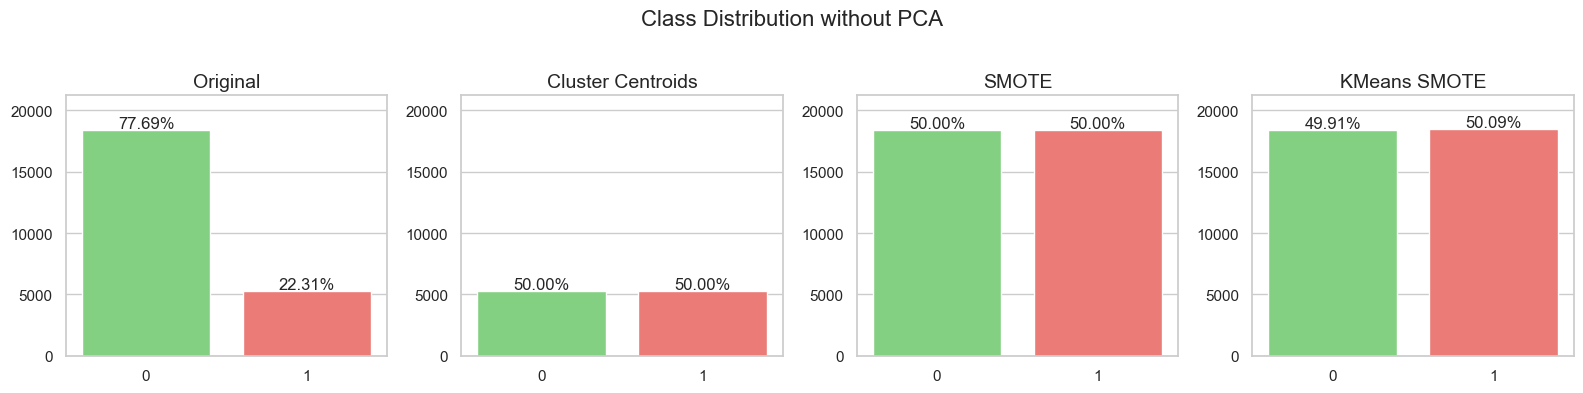

In [88]:
import resamplingModule
import importlib
importlib.reload(resamplingModule)

# Now call the function from the reloaded module
result = resamplingModule.resample_and_plot(
    X_train_norm,
    y_train,
    title_suffix="without PCA",
    save_path="../images/resampling_nonPca.svg"
)


In [89]:
result['Original']


(array([[0.0379746835443038, 0.24137931034482757, 0.2, ..., False, False,
         False],
        [0.6582278481012659, 0.49999999999999994, 0.2, ..., True, False,
         True],
        [0.20253164556962022, 0.13793103448275862, 0.2, ..., False, False,
         False],
        ...,
        [0.08860759493670886, 0.051724137931034475, 0.2, ..., False, True,
         False],
        [0.34177215189873417, 0.3620689655172414, 0.2, ..., False, True,
         True],
        [0.5569620253164557, 0.17241379310344823, 0.0, ..., False, False,
         False]], dtype=object),
 array([0, 0, 0, ..., 1, 0, 0], dtype=int64))

In [90]:
columnList = X_test_norm.columns.tolist()
classBalancingTechnique = ['Orignal' , 'SMOTE', 'KMeans SMOTE', 'Cluster Centroids']
# for(str : classBalancingTechnique):


In [91]:
def train_and_save_logistic_model(X_train, y_train, regularisation ,  model_save_path ,  verbose=True):
    """
    Trains a logistic regression model with hyperparameter tuning and feature selection.
    
    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Target labels.
        model_save_path (str): Path to save the trained model.
        verbose (bool): If True, prints the reduced features.
        
    Returns:
        model (sklearn Pipeline): Trained model pipeline.
        removed_features (list): List of feature names removed.
    """
    # Keep track of feature names
    feature_names =list(range(X_train.shape[1]))


    # Standardize features
    scaler = StandardScaler()

    # Base Logistic Regression model for feature selection
    base_logreg = LogisticRegression(penalty=regularisation, solver='liblinear', random_state=42)

    # Feature selector
    selector = SelectFromModel(base_logreg)

    # Final Logistic Regression model for tuning
    final_logreg = LogisticRegression(solver='liblinear', random_state=42)

    # Grid of hyperparameters
    param_grid = {
        'logistic__C': [0.01, 0.1, 1, 10, 100]
    }

    # Full pipeline
    pipe = Pipeline([
        ('scaler', scaler),
        ('feature_selection', selector),
        ('logistic', final_logreg)
    ])

    # Grid Search with Cross-Validation
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1' ,n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Save the model
    joblib.dump(grid_search.best_estimator_, model_save_path)

    # Identify selected features
    selector_model = grid_search.best_estimator_.named_steps['feature_selection']

    # selected_features = np.array(feature_names)[mask]
    # removed_features = list(set(feature_names) - set(selected_features))

    # if verbose:
    #     print("Selected Features:")
    #     print(selected_features)
    #     print("\nRemoved Features:")
    #     print(removed_features)

    return grid_search.best_estimator_


In [92]:
# # model, removed_cols = train_and_save_logistic_model(X_train, y_train, "logistic_model.pkl")
# model, removed_cols = train_and_save_logistic_model(
#     X_train_final_pca, y_train, "../models/baseline_models/logistic_model_pca.pkl"
# )

In [93]:
X_test_norm_array = X_test_norm.to_numpy()
y_test_array = y_test.to_numpy()


In [94]:
def modelDetails(model, X_test, y_test):
    """
    Evaluates the model on test data and prints key metrics and plots the confusion matrix.
    
    Parameters:
        model : Trained sklearn-compatible model
        X_test (np.ndarray): Test feature array
        y_test (np.ndarray): True labels
    """
    # Get predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary' if len(np.unique(y_test)) == 2 else 'macro')
    rec = recall_score(y_test, y_pred, average='binary' if len(np.unique(y_test)) == 2 else 'macro')
    f1 = f1_score(y_test, y_pred, average='binary' if len(np.unique(y_test)) == 2 else 'macro')

    # Print metrics
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    print("=== Summary Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.98      0.88      4600
           1       0.69      0.19      0.30      1321

    accuracy                           0.80      5921
   macro avg       0.75      0.58      0.59      5921
weighted avg       0.78      0.80      0.75      5921

=== Summary Metrics ===
Accuracy : 0.8007
Precision: 0.6932
Recall   : 0.1915
F1 Score : 0.3001


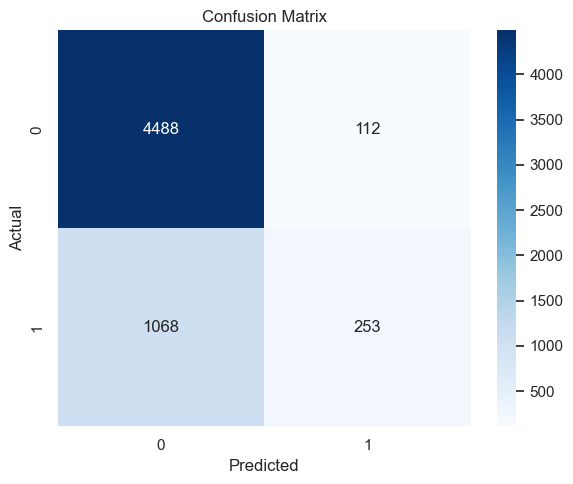

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4600
           1       0.67      0.15      0.24      1321

    accuracy                           0.79      5921
   macro avg       0.74      0.56      0.56      5921
weighted avg       0.77      0.79      0.74      5921

=== Summary Metrics ===
Accuracy : 0.7934
Precision: 0.6713
Recall   : 0.1453
F1 Score : 0.2390


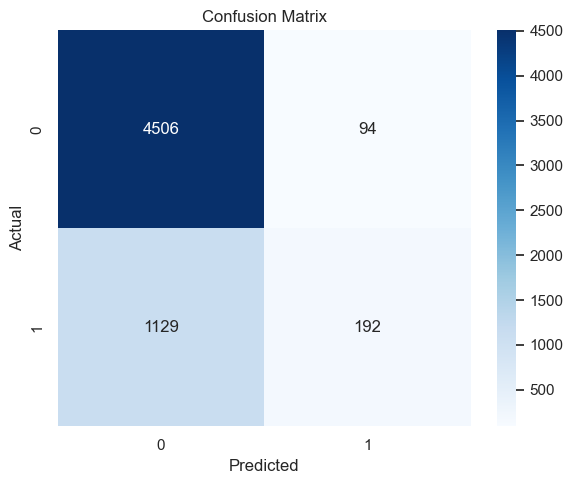

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.87      0.61      0.72      4600
           1       0.33      0.67      0.45      1321

    accuracy                           0.63      5921
   macro avg       0.60      0.64      0.58      5921
weighted avg       0.75      0.63      0.66      5921

=== Summary Metrics ===
Accuracy : 0.6266
Precision: 0.3333
Recall   : 0.6737
F1 Score : 0.4460


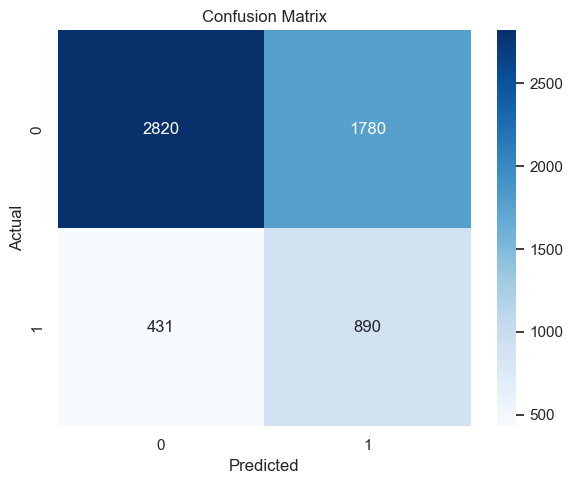

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.59      0.70      4600
           1       0.32      0.67      0.43      1321

    accuracy                           0.61      5921
   macro avg       0.59      0.63      0.57      5921
weighted avg       0.74      0.61      0.64      5921

=== Summary Metrics ===
Accuracy : 0.6099
Precision: 0.3212
Recall   : 0.6722
F1 Score : 0.4347


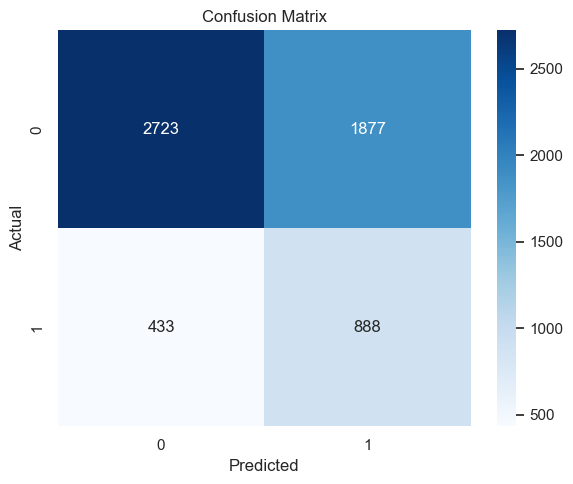

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.65      0.74      4600
           1       0.34      0.63      0.44      1321

    accuracy                           0.65      5921
   macro avg       0.60      0.64      0.59      5921
weighted avg       0.74      0.65      0.67      5921

=== Summary Metrics ===
Accuracy : 0.6452
Precision: 0.3399
Recall   : 0.6268
F1 Score : 0.4408


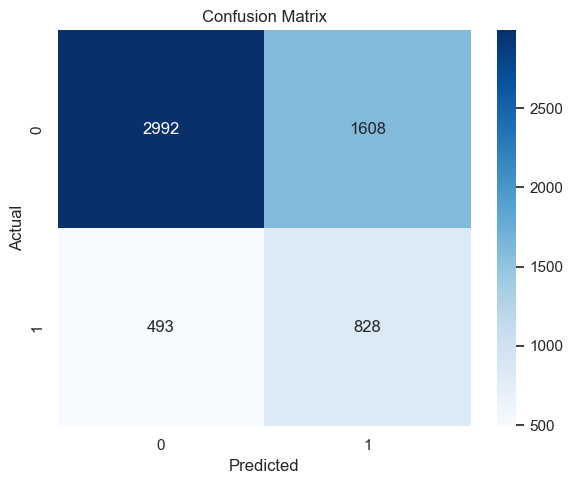

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.63      0.72      4600
           1       0.33      0.62      0.43      1321

    accuracy                           0.63      5921
   macro avg       0.59      0.63      0.58      5921
weighted avg       0.74      0.63      0.66      5921

=== Summary Metrics ===
Accuracy : 0.6276
Precision: 0.3252
Recall   : 0.6223
F1 Score : 0.4271


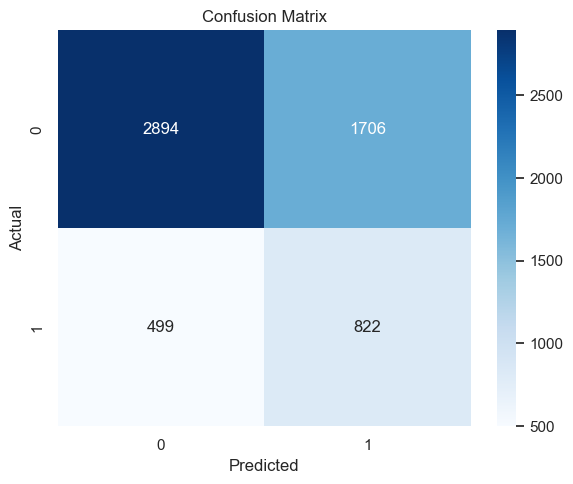

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.48      0.62      4600
           1       0.29      0.74      0.42      1321

    accuracy                           0.54      5921
   macro avg       0.58      0.61      0.52      5921
weighted avg       0.74      0.54      0.57      5921

=== Summary Metrics ===
Accuracy : 0.5383
Precision: 0.2894
Recall   : 0.7350
F1 Score : 0.4153


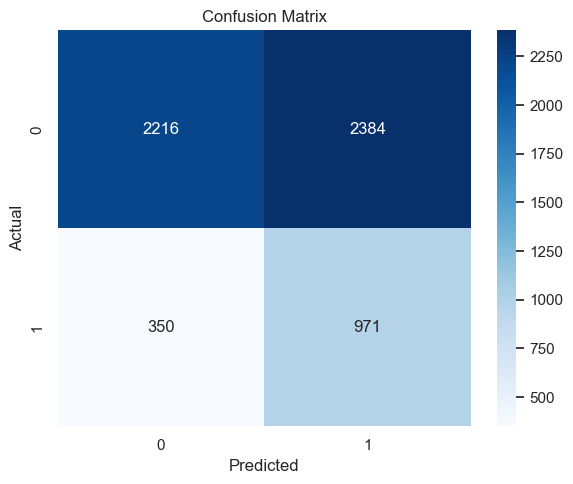

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.51      0.64      4600
           1       0.30      0.71      0.42      1321

    accuracy                           0.56      5921
   macro avg       0.58      0.61      0.53      5921
weighted avg       0.74      0.56      0.59      5921

=== Summary Metrics ===
Accuracy : 0.5575
Precision: 0.2959
Recall   : 0.7131
F1 Score : 0.4183


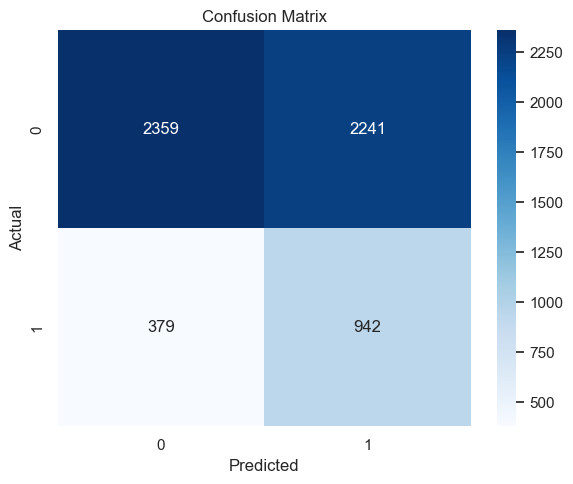

In [95]:
classBalancingTechnique = ['Original' , 'SMOTE', 'KMeans SMOTE', 'Cluster Centroids']
for tech in classBalancingTechnique:
    model = train_and_save_logistic_model(
        result[tech][0], result[tech][1],'l1',
        f"../models/baseline_models/logistic_model_without_pca_{tech}_l1.pkl"
    )
    modelDetails(model , X_test_norm_array, y_test_array )
    model = train_and_save_logistic_model(
        result[tech][0], result[tech][1],'l2',
        f"../models/baseline_models/logistic_model_without_pca_{tech}_l2.pkl"
    )
    modelDetails(model , X_test_norm_array, y_test_array )

In [99]:
def evaluate_models(result, X_test, y_test):
    balancing_methods = ['Original', 'SMOTE', 'KMeans SMOTE', 'Cluster Centroids']
    penalties = ['l1', 'l2']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    
    scores = []
    # Iterate through each combination of balancing method and penalty
    for tech in balancing_methods:
        for penalty in penalties:
            # Load model
            model_path = f"../models/baseline_models/logistic_model_without_pca_{tech}_{penalty}.pkl"
            model = joblib.load(model_path)
            
            # Predict
            y_pred = model.predict(X_test)

            # Collect scores
            scores.append({
                'Technique': tech,
                'Penalty': penalty,
                'Model': f'{tech}_{penalty}',
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, zero_division=0),
                'Recall': recall_score(y_test, y_pred, zero_division=0),
                'F1 Score': f1_score(y_test, y_pred, zero_division=0)
            })

    return scores


In [100]:
def plot_model_comparison(scores):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    df = pd.DataFrame(scores)

    # Melt for easier Seaborn plotting
    df_melted = df.melt(
        id_vars=['Model'],
        value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        var_name='Metric',
        value_name='Score'
    )

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
    plt.title("Model Comparison Across Balancing Techniques and Penalties")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Colors for metric lines (Seaborn's default palette has 10 colors)
    palette = sns.color_palette("tab10")
    metric_colors = {
        'Accuracy': palette[0],
        'Precision': palette[1],
        'Recall': palette[2],
        'F1 Score': palette[3]
    }

    # Plot max lines per metric
    for metric, color in metric_colors.items():
        max_value = df[metric].max()
        ax.axhline(y=max_value, linestyle='--', color=color, alpha=0.6, linewidth=1.5)
        ax.text(
            len(df['Model'].unique()) - 0.5, max_value + 0.01,
            f'Max {metric}: {max_value:.2f}',
            color=color, fontsize=9, ha='right', va='bottom'
        )

    plt.show()


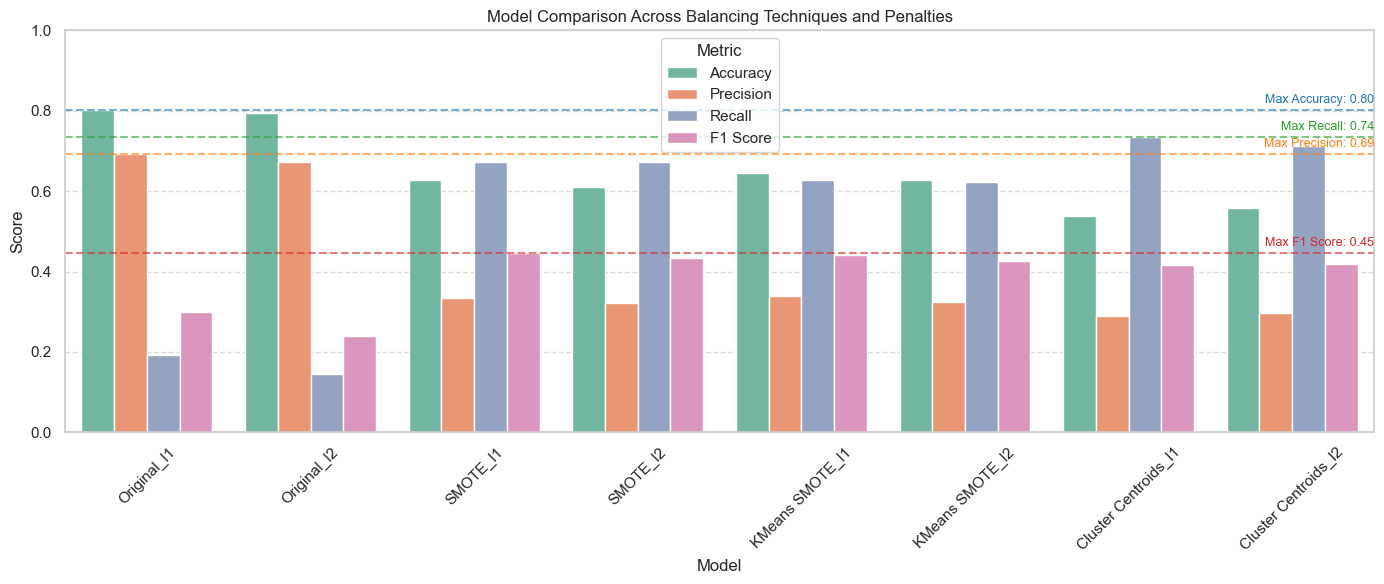

In [101]:
scores = evaluate_models(result, X_test_norm_array, y_test_array)
plot_model_comparison(scores)
